<a href="https://colab.research.google.com/github/raghavmehta1/Accredian-backend-task/blob/master/Autism_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Dependencies and Setup

In [26]:
import tensorflow as tf
import os as os

In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. Remove Unwanted images

In [29]:
import cv2
import imghdr

In [30]:
!pip install kagglehub


In [31]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [32]:
import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("cihan063/autism-image-data")


In [33]:
data_dir = path
print("Path to dataset files:", data_dir)


Path to dataset files: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1


In [34]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/consolidated
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/test
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/valid
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/train


In [35]:
os.listdir(data_dir)

['AutismDataset']

# 3. Load **Data**

In [36]:
import numpy as np
from matplotlib import pyplot as plt

In [37]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)


Found 5880 files belonging to 1 classes.


In [38]:
tf.keras.utils.image_dataset_from_directory??

In [39]:
data_iterator = data.as_numpy_iterator()

In [40]:
batch = data_iterator.next()

In [41]:
batch[0].shape

(32, 256, 256, 3)

In [42]:
#batch[1]

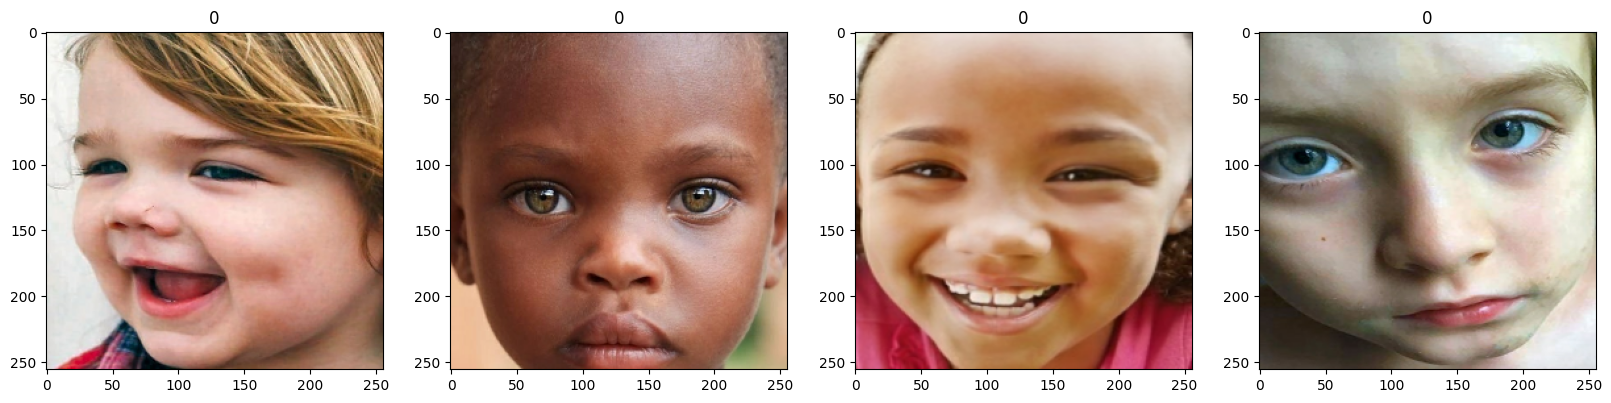

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [44]:
data = data.map(lambda x,y: (x/255, y))

In [45]:
data.as_numpy_iterator().next()

(array([[[[0.5447491 , 0.77592474, 0.68857026],
          [0.5410701 , 0.76764876, 0.66528964],
          [0.42740753, 0.6470154 , 0.52249026],
          ...,
          [0.32641512, 0.48018536, 0.37339154],
          [0.31151667, 0.4809641 , 0.38165343],
          [0.3136994 , 0.47654137, 0.3955847 ]],
 
         [[0.552502  , 0.7914968 , 0.70172155],
          [0.4556616 , 0.68663585, 0.5842768 ],
          [0.40724906, 0.62563354, 0.50477856],
          ...,
          [0.3721229 , 0.51119447, 0.40743372],
          [0.33389774, 0.4857819 , 0.38757294],
          [0.29881796, 0.44943962, 0.36092052]],
 
         [[0.45097154, 0.69196975, 0.60152674],
          [0.4225803 , 0.6567945 , 0.55364233],
          [0.43555447, 0.66020536, 0.539522  ],
          ...,
          [0.39857453, 0.5193377 , 0.42181653],
          [0.37708825, 0.5061783 , 0.40945303],
          [0.32378587, 0.46096256, 0.3655867 ]],
 
         ...,
 
         [[0.5119211 , 0.35205594, 0.03724096],
          [0.51125

In [46]:
batch[0].max()

255.0

In [47]:
len(data)

184

5. Split Data

In [48]:
train_size = int(len(data)*.75)+1
val_size = int(len(data)*.15)
test_size = int(len(data)*.1)

In [49]:
train_size+val_size+test_size

184

In [50]:
train_size

139

In [51]:
val_size

27

In [52]:
test_size

18

In [53]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#6. Build Deep Learning Model

In [54]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create a Sequential model
model = Sequential()

# Define the input shape using an Input layer
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding Dropout for regularization
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# Compile the model with 'learning_rate' instead of 'lr'
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Load your training and validation data using train_datagen

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
# model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stop, reduce_lr])


In [57]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 127, 127, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,905 (14.11 MB)

 Trainable params: 3,697,265 (14.10 MB)

 Non-trainable params: 640 (2.50 KB)

7. Train

In [58]:
logdir='logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
history = model.fit(
    train,
    epochs=5,
    validation_data=val,
    callbacks=[early_stop, reduce_lr])

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9999 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 7.6721e-04 - learning_rate: 0.0010
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 5.5864e-04 - learning_rate: 0.0010
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 5.0252e-04 - learning_rate: 0.0010
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 1.0000 - loss: 9.0100e-04 - val_accuracy: 1.0000 - val_loss: 3.2542e-04 - learning_rate: 0.0010
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 1.0000 - loss: 8.2735e-04 - val_accuracy: 1.0000 - val_loss: 2.6651e-04 - learning_rate: 0.0010


8. Plot Performance

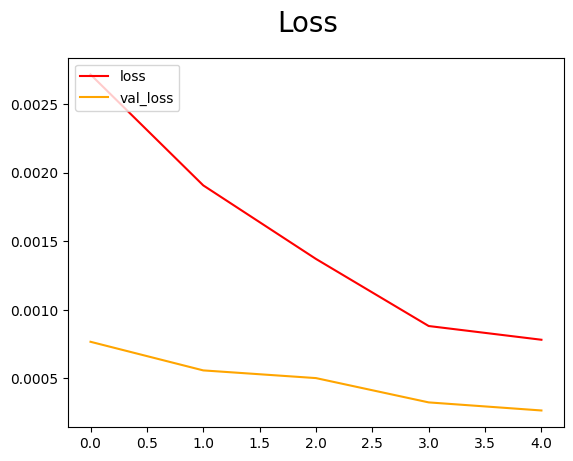

In [62]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

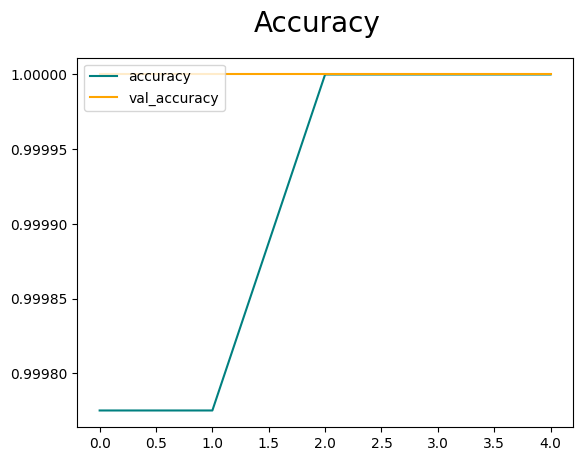

In [63]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [64]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator():
    X, y = batch
    z = model.predict(X)
    pre.update_state(y, z)
    re.update_state(y, z)
    acc.update_state(y, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


In [68]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


10. Test

In [69]:
import cv2 as cv2

Dataset Path: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1
Top-level files and folders in dataset: ['AutismDataset']
Files in the 'test' folder: ['Autistic.31.jpg', 'Non_Autistic.20.jpg', 'Non_Autistic.10.jpg', 'Autistic.65.jpg', 'Autistic.49.jpg', 'Autistic.63.jpg', 'Non_Autistic.117.jpg', 'Autistic.106.jpg', 'Autistic.112.jpg', 'Non_Autistic.94.jpg', 'Non_Autistic.32.jpg', 'Autistic.3.jpg', 'Autistic.92.jpg', 'Autistic.70.jpg', 'Non_Autistic.74.jpg', 'Autistic.45.jpg', 'Non_Autistic.48.jpg', 'Autistic.28.jpg', 'Autistic.74.jpg', 'Non_Autistic.131.jpg', 'Autistic.30.jpg', 'Non_Autistic.144.jpg', 'Autistic.16.jpg', 'Non_Autistic.13.jpg', 'Non_Autistic.58.jpg', 'Non_Autistic.40.jpg', 'Autistic.127.jpg', 'Autistic.21.jpg', 'Autistic.25.jpg', 'Autistic.148.jpg', 'Non_Autistic.64.jpg', 'Non_Autistic.22.jpg', 'Non_Autistic.149.jpg', 'Autistic.145.jpg', 'Non_Autistic.4.jpg', 'Non_Autistic.84.jpg', 'Autistic.34.jpg', 'Autistic.22.jpg', 'Autistic.29.jpg', 'Autistic.55.

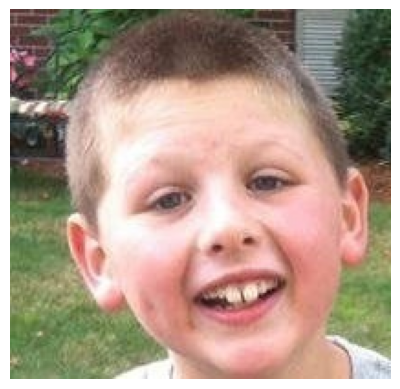

In [88]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt

# Download the dataset from Kaggle and get the path
path = kagglehub.dataset_download("cihan063/autism-image-data")

# Print the dataset path and check the top-level structure
print("Dataset Path:", path)
print("Top-level files and folders in dataset:", os.listdir(path))  # List the contents

# Check the structure of the 'test' folder
test_dir = os.path.join(path, 'AutismDataset', 'test')
if os.path.exists(test_dir):
    print(f"Files in the 'test' folder: {os.listdir(test_dir)}")
else:
    print(f"'test' folder does not exist. Please check the directory structure.")

# Define the image path within the downloaded dataset
img_path = os.path.join(test_dir, "Autistic.134.jpg")

# Ensure the image exists at the specified path
if os.path.exists(img_path):
    # Read and display the image
    img = cv2.imread(img_path)  # Read image using OpenCV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found. Please verify the image name and path.")


print("Dataset Path:", path)


In [90]:
import os

# Get the path from Kaggle dataset
path = kagglehub.dataset_download("cihan063/autism-image-data")

# Print the dataset path to understand its structure
print("Dataset Path:", path)

# Check the contents at the root level of the dataset
root_contents = os.listdir(path)
print("Contents of the dataset:", root_contents)

# Check if 'AutismDataset' is a subfolder or not and locate the 'test' folder
if 'AutismDataset' in root_contents:
    sub_dir_path = os.path.join(path, 'AutismDataset', 'test')  # If 'AutismDataset' folder exists
else:
    sub_dir_path = os.path.join(path, 'test')  # If 'test' is directly in the root folder

# Print the contents of the 'test' folder
if os.path.exists(sub_dir_path):
    print("Contents of the 'test' folder:", os.listdir(sub_dir_path))
else:
    print(f"The 'test' folder was not found at {sub_dir_path}. Please verify the folder structure.")


Dataset Path: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1
Contents of the dataset: ['AutismDataset']
Contents of the 'test' folder: ['Autistic.31.jpg', 'Non_Autistic.20.jpg', 'Non_Autistic.10.jpg', 'Autistic.65.jpg', 'Autistic.49.jpg', 'Autistic.63.jpg', 'Non_Autistic.117.jpg', 'Autistic.106.jpg', 'Autistic.112.jpg', 'Non_Autistic.94.jpg', 'Non_Autistic.32.jpg', 'Autistic.3.jpg', 'Autistic.92.jpg', 'Autistic.70.jpg', 'Non_Autistic.74.jpg', 'Autistic.45.jpg', 'Non_Autistic.48.jpg', 'Autistic.28.jpg', 'Autistic.74.jpg', 'Non_Autistic.131.jpg', 'Autistic.30.jpg', 'Non_Autistic.144.jpg', 'Autistic.16.jpg', 'Non_Autistic.13.jpg', 'Non_Autistic.58.jpg', 'Non_Autistic.40.jpg', 'Autistic.127.jpg', 'Autistic.21.jpg', 'Autistic.25.jpg', 'Autistic.148.jpg', 'Non_Autistic.64.jpg', 'Non_Autistic.22.jpg', 'Non_Autistic.149.jpg', 'Autistic.145.jpg', 'Non_Autistic.4.jpg', 'Non_Autistic.84.jpg', 'Autistic.34.jpg', 'Autistic.22.jpg', 'Autistic.29.jpg', 'Autistic.55.jpg', 'Non_A

In [79]:
!pip install opencv-python


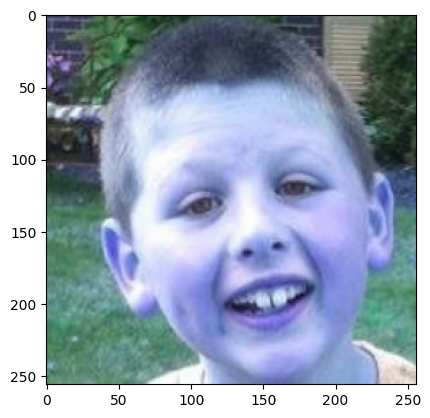

In [91]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [92]:
z= model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


In [ ]:
z

In [93]:
if z > 0.015:
    print(f'Predicted photo is Not Autistic')
else:
    print(f'Predicted photo is Autistic')

Predicted photo is Autistic


*5.Saving the model*

In [94]:
tf.keras.models.save_model(model,'my_model2.hdf5')